# EOSC 454 Assignment 2
### February 9, 2026
### Ian Hartley

## Problem 2
### $v_{int} = v_0 + \alpha \sin{(\omega t)} + \beta t$

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [47]:
def calc_v_int(v0:float|int, alpha:float, beta: float|int, omega: float|int, time):
    """Calculate interval velocity of the form v_int(t) = v0 + alpha * sin(omega t) + beta t

    :param v0: initial velocity [L]/[T]
    :param alpha: sine wave amplitude
    :param beta: linear velocity ramp amplidute [L]/[T^2]
    :param omega: angular frequency [T^-1]
    :param time: list of times at which v_int should be evaluated [T]
    :return v_int: list of velocities calculated at the times in list t [L]/[T]
    
    """

    return [v0 + alpha*np.sin(omega*ti) + beta*ti for ti in time]

2a: Plot the interval velocity using v0 = 2000m/s, α = 50m/s, β = 20m/s2 and with
0s ≤ t ≤ 2s

Text(0.5, 1.0, 'Interval velocity')

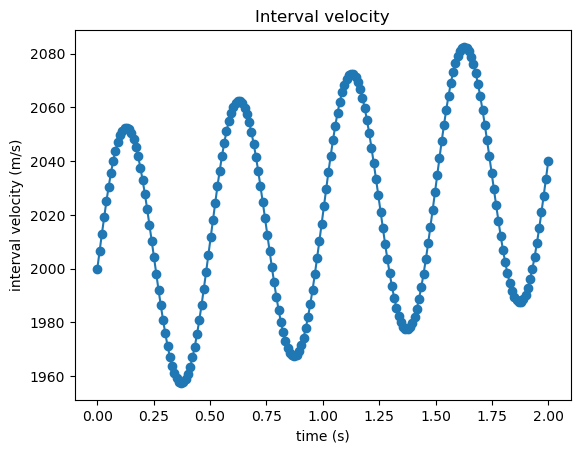

In [48]:
v0 = 2000
alpha = 50
beta = 20
omega = 2 * 2*np.pi
time = np.linspace(0,2,200)

v_int = calc_v_int(v0,alpha,beta,omega,time)

plt.plot(time,v_int, "-o")
plt.xlabel("time (s)")
plt.ylabel("interval velocity (m/s)")
plt.title("Interval velocity")


b. Describe how each of the parameters v0, α, β, and ω influence the character of
the interval velocity. 

### $v_0$

Changing $v_0$ sets the initial value of velocity (assuming $t = 0$ initially) and applies a constant offset of that value to the interval velocity. The effects of varying $v_0$ are shown in the first row of plots below.

### $\alpha$

$\alpha$ sets the amplitude of the sine wave, this means that a high alpha results in large oscillations in the interval velocity, while smaller alpha values result in smaller oscillations. The effects of varying $\alpha$ are shown in the second row of plots below.


### $\omega$

$\omega$ sets the angular frequency of the sine term. High $\omega$ means lots of fast oscillations, while low $\omega$ results in slower oscillations. The effects of varying $\omega$ are shown in the third row of plots below.


### $\beta$ 

$\beta$ sets the slope of the change of velocity with time. Positive beta means the velocity increases over time, negative means velocity decreases over time. The effects of varying $\beta$ are shown in the fourth row of plots below.




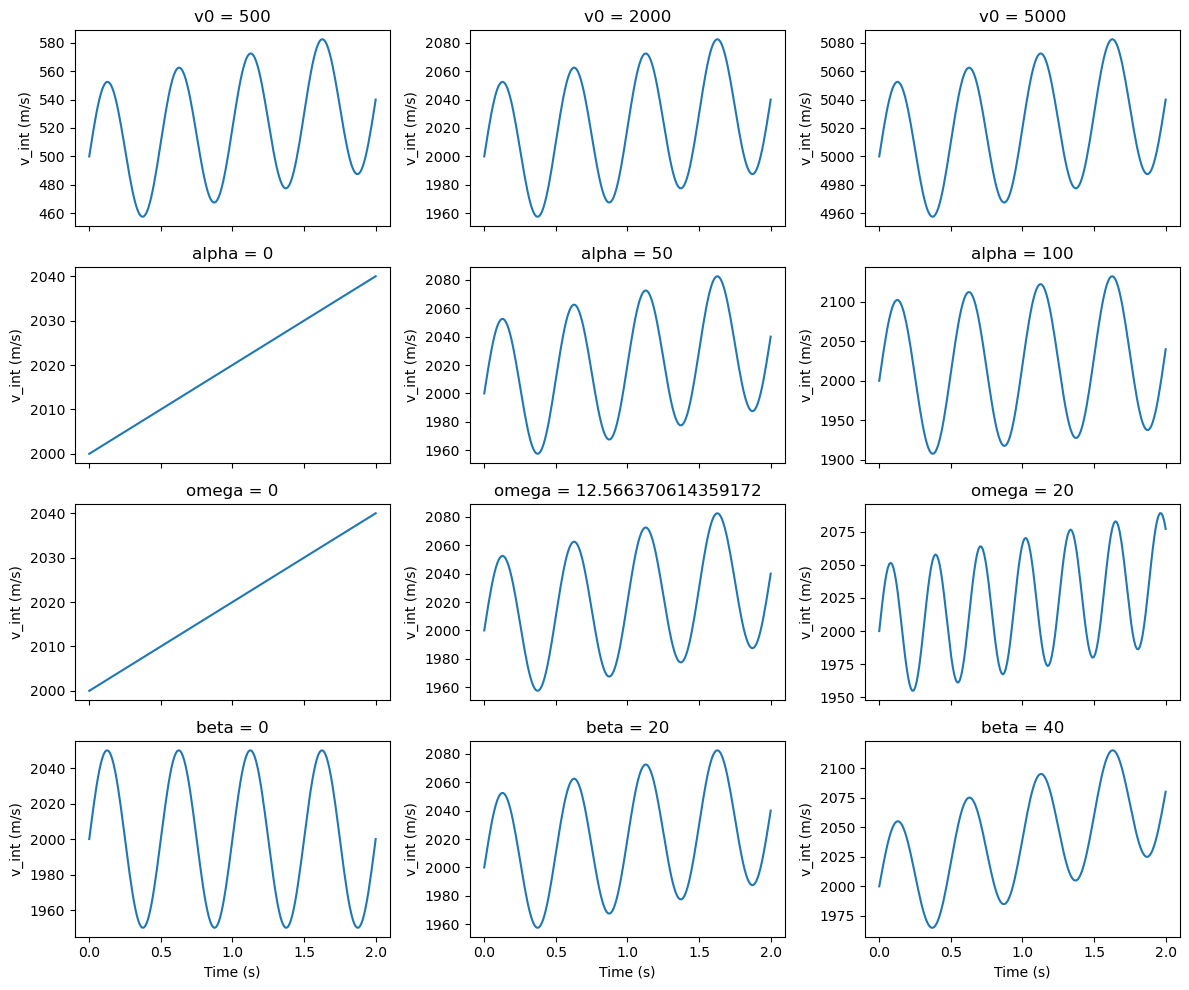

In [49]:
# default parameters
defaults = {
    "v0": 2000,
    "alpha": 50,
    "omega": 2 * 2 * np.pi,
    "beta": 20,
}

# parameter variations (low, medium, high)
sweeps = {
    "v0":    [500, 2000, 5000],
    "alpha": [0, 50, 100],
    "omega": [0, 2 * 2 * np.pi, 20],
    "beta":  [0, 20, 40],
}

# create 4x3 plot grid
fig, axes = plt.subplots(4, 3, figsize=(12, 10), sharex=True)

for row, (param, values) in enumerate(sweeps.items()):
    for col, val in enumerate(values):
        params = defaults.copy()
        params[param] = val

        v_int = calc_v_int(
            v0=params["v0"],
            alpha=params["alpha"],
            beta=params["beta"],
            omega=params["omega"],
            time=time,
        )

        ax = axes[row, col]
        ax.plot(time, v_int)
        ax.set_title(f"{param} = {val}")
        ax.set_ylabel("v_int (m/s)")

for ax in axes[-1]:
    ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [50]:
def rms_velocity(v0: float|int, alpha:float, beta: float|int, omega: float|int, time):
    t_nonzero = time > 0
    vrms = np.zeros(len(time))

    if omega > 0:
        term1 = 2*alpha*v0/omega
        term2 = omega*((-24*alpha*v0-24*alpha*beta*time[t_nonzero])*np.cos(time[t_nonzero]*omega)- 3*alpha**2*np.sin(2*time[t_nonzero]*omega))
        term3 = 24*alpha*beta*np.sin(omega*time[t_nonzero])
        term4 = omega**2*(12*time[t_nonzero]*v0**2+12*beta*time[t_nonzero]**2*v0+4*beta**2*time[t_nonzero]**3+6*alpha**2*time[t_nonzero])
        vrms2 = np.sqrt(1/time[t_nonzero]*(term1 + (term2 + term3 + term4)/(12*omega**2)))
        vrms[t_nonzero] = vrms2
        vrms[~t_nonzero] = v0
    else: 
        vrms = np.sqrt((time**2*beta**2+3*time*v0*beta+3*v0**2)/3)
    return vrms


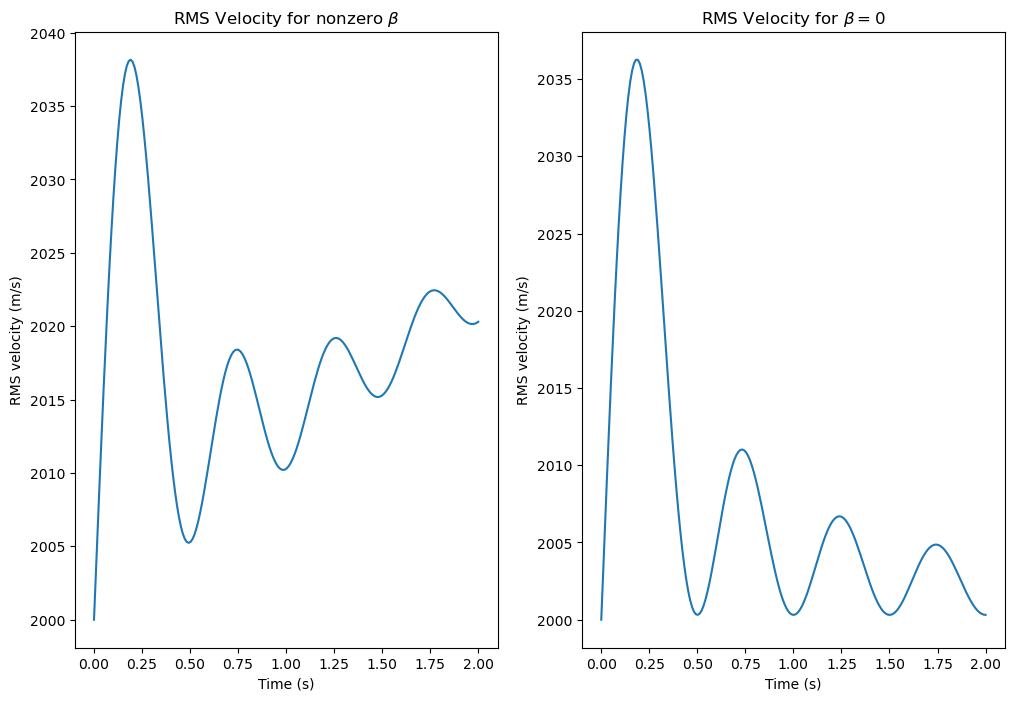

In [51]:
v_rms_beta_0 = rms_velocity(v0, alpha,0, omega, time)
v_rms = rms_velocity(v0, alpha, beta, omega, time)
fig, axes =  plt.subplots(1, 2, figsize=(12, 8))
axes[0].plot(time, v_rms)
axes[1].plot(time, v_rms_beta_0)
axes[0].set_title("RMS Velocity for nonzero $\\beta$")
axes[1].set_title("RMS Velocity for $\\beta = 0$")

for ax in axes:
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("RMS velocity (m/s)")


In [52]:
def approx_v_int(time, v_rms):
    """Approximate the interval velocity using rms velocity and finite difference methods

    :param time: vector of timesteps that corresponds to the time at which the vrms values are generated
    :param v_rms: vector of vrms velocities
    :return v_int: vector of interval velocities calculated using the vrms data"""

    vrms_grad = np.gradient(v_rms, time)
    return v_rms*(1+2*time*vrms_grad/v_rms)**(0.5)



## Downsampling v_rms

Text(0, 0.5, 'RMS velocity (m/s)')

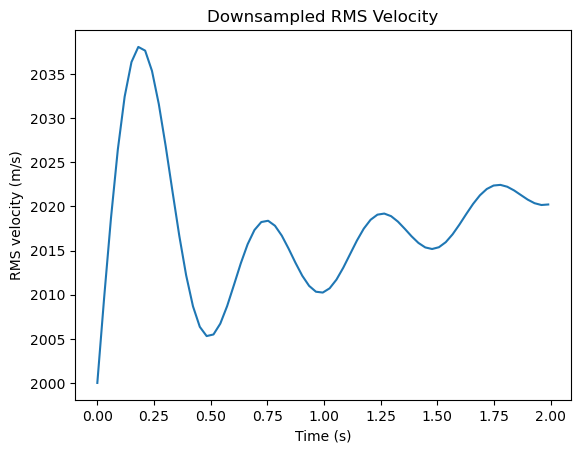

In [53]:
downsample_factor = 3
v_rms_downsampled = v_rms[::downsample_factor]
time_downsampled = time[::downsample_factor]
plt.plot(time_downsampled, v_rms_downsampled)
plt.title("Downsampled RMS Velocity")
plt.xlabel("Time (s)")
plt.ylabel("RMS velocity (m/s)")

## Interpolation

In [56]:
spline_interp = interp1d(time_downsampled, v_rms_downsampled, kind="cubic", fill_value="extrapolate")

v_rms_spline_interp = spline_interp(time)

linear_interp = interp1d(time_downsampled, v_rms_downsampled, kind="linear", fill_value="extrapolate")

v_rms_linear_interp = linear_interp(time)



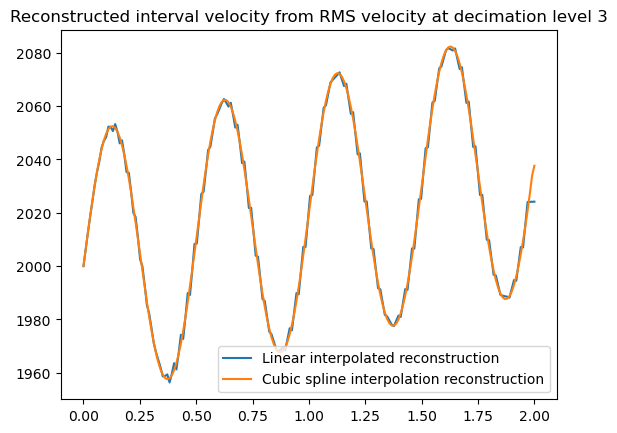

In [58]:
v_int_linear =approx_v_int(time, v_rms_linear_interp)
v_int_spline = approx_v_int(time, v_rms_spline_interp)
plt.title(f"Reconstructed interval velocity from RMS velocity at decimation level {3}")
plt.plot(time, v_int_linear, label = "Linear interpolated reconstruction")
plt.plot(time, v_int_spline, label = "Cubic spline interpolation reconstruction")
plt.legend()


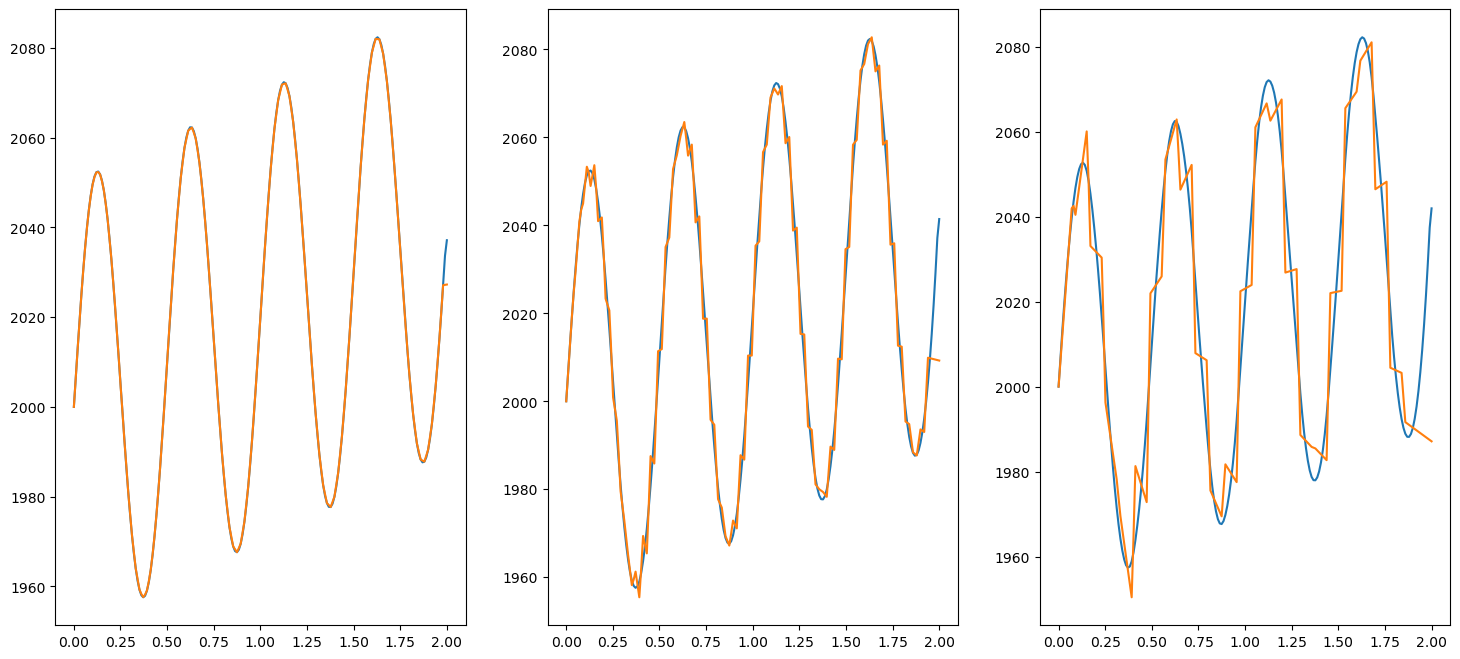

In [63]:
decimation_levels = [2,4,8]
v_rms_spline_interps = np.zeros((len(decimation_levels), len(time)))
v_rms_linear_interps = np.zeros((len(decimation_levels), len(time)))
v_int_recs_spline = np.zeros((len(decimation_levels), len(time)))
v_int_recs_linear = np.zeros((len(decimation_levels), len(time)))
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
for i, decimation_level in enumerate(decimation_levels):
    spline_interp = interp1d(time[::decimation_level], v_rms[::decimation_level], kind="cubic", fill_value="extrapolate")

    v_rms_spline_interps[i][:] = spline_interp(time)

    linear_interp = interp1d(time[::decimation_level], v_rms[::decimation_level], kind="linear", fill_value="extrapolate")

    v_rms_linear_interps[i][:] = linear_interp(time)
    v_int_recs_linear[i][:] = approx_v_int(time, v_rms_linear_interps[i][:])
    v_int_recs_spline[i][:] = approx_v_int(time, v_rms_spline_interps[i][:])
    axes[i].plot(time, v_int_recs_spline[i][:], label = "Cubic spline interpolation reconstruction")
    axes[i].plot(time, v_int_recs_linear[i][:], label ="Linear interpolated reconstruction")


